In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%tensorflow_version 1.x
%matplotlib inline

TensorFlow 1.x selected.


In [2]:
data = pd.read_csv("/content/drive/My Drive/BERT/ANTON/final.csv")
data = data.drop("Unnamed: 0", axis=1)
data.head()

,review_rate,review_body
0,10,"Pois bem...as fotos dos pratos, bebidas e doce..."
1,30,Espero que utilizem essa avaliação para rever ...
2,20,"Fomos comer a sobremesa as 20h40, sentamos, pe..."
3,10,Pedimos o cardápio e ao chamar o atendente ped...
4,50,"Fui com algumas amigas em uma segunda-feira, d..."


In [3]:
def DATA_BINARIZADOR_RESULTADOS(data):
    RESULTADO_BINARIO = []
    
    for item in data['review_rate']:
        if item < 40 :
            RESULTADO_BINARIO.append(0)
        elif item >= 40:
            RESULTADO_BINARIO.append(1)
        else:
            print("algo deu ruim")
            
    
    data['review_rate'] = RESULTADO_BINARIO
    return data
data = DATA_BINARIZADOR_RESULTADOS(data)
data.head(10)

,review_rate,review_body
0,0,"Pois bem...as fotos dos pratos, bebidas e doce..."
1,0,Espero que utilizem essa avaliação para rever ...
2,0,"Fomos comer a sobremesa as 20h40, sentamos, pe..."
3,0,Pedimos o cardápio e ao chamar o atendente ped...
4,1,"Fui com algumas amigas em uma segunda-feira, d..."
5,1,"Quem gosta de doce, é um prato cheio. Erramos ..."
6,0,"Atendimento muito bom, confesso que quase peca..."
7,0,"As sobremesas são realmente uma delícia, porém..."
8,1,O bar oferece diversas opções de comidinhas de...
9,1,"Ao chegar, o local já agrada. Tanto o visual, ..."


In [0]:
from sklearn.model_selection import train_test_split

X = data.review_body.values
y = data.review_rate.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'Há {torch.cuda.device_count()} GPU(s) disponivel.')
    print('Nome:', torch.cuda.get_device_name(0))

else:
    print('Sem GPU, usando a CPU.')
    device = torch.device("cpu")

Há 1 GPU(s) disponivel.
Nome: Tesla P100-PCIE-16GB


In [0]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
  
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
 
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Acurácia: {accuracy*100:.2f}%')
    
    # Plotando a ROC
    plt.title('Curva ROC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Taxa de true positive')
    plt.xlabel('Taxa de false positive ')
    plt.show()

In [7]:
!pip install transformers

     |████████████████████████████████| 573kB 8.6MB/s 
     |████████████████████████████████| 890kB 54.9MB/s 
     |████████████████████████████████| 1.0MB 48.2MB/s 
     |████████████████████████████████| 3.7MB 32.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=3031d1046c45f5f068282206c4dcecccba7f4e10c1e410ae45efc8ac6708ce21
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [8]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [9]:
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in data.review_body]
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (1191 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (830 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (696 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (784 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Max length:  1193


In [0]:
def text_preprocessing(text):
   
 
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [12]:
MAX_LEN = 64

token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)


print('Tokenizando os dados...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original:  Pois bem...as fotos dos pratos, bebidas e doces são maravilhosas...daquelas q vc se empolga e diz: vale a pena conhecer.. porém tudo acaba quando vc entra...infelizmente.Cheguei com meu marido e sentamos.. mesa suja..mas ficamos aguardando o atendimento...5 min., 10 min., (o atendente chegou na mesa ao lado, tirou o pedido e nada de nos atender.Outro atendente serviu a outra mesa ao lado..13 minutos. Apertamos o botão pra acionar o atendente (aquele q fica na mesa) e continuamos aguardando..15 min., 20 min.(e a gente só de olho...)..a mesa ainda suja.Finalmente passados 25 minutos apareceu a atendente Tainá e ao explicarmos o ocorrido, ficava mais olhando a mesa ao lado do que nos ouvindo..teve a coragem ainda de interromper o que estávamos falando pra perguntar pra mesa ao lado se estava tudo ok com eles!tipo: conversa com a minha mão! Nessas eu disse: chega! Ela nem está ouvindo o que estamos falando ( q era: olha vcs devem estar correndo aí.. agora não da tempo de pedirmo

In [0]:
#CRIANDO O DATALOADER:

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)


batch_size = 32


train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [14]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel


class BertClassifier(nn.Module):
   
    def __init__(self, freeze_bert=False):
     
        super(BertClassifier, self).__init__()
        D_in, H, D_out = 768, 50, 2

    
        self.bert = BertModel.from_pretrained('bert-base-multilingual-uncased')

     
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
         
            nn.Linear(H, D_out)
        )

      
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
         
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
      
        last_hidden_state_cls = outputs[0][:, 0, :]

        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 45 µs, sys: 0 ns, total: 45 µs
Wall time: 47.4 µs


In [0]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
   
    
    bert_classifier = BertClassifier(freeze_bert=False)

    
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,   
                      eps=1e-8  
                      )

    
    total_steps = len(train_dataloader) * epochs

    
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, 
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [0]:
import random
import time


loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
   
    print("Treino iniciado...\n")
    for epoch_i in range(epochs):

        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val. Acuracia':^9} | {'Tempo':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()

       
        total_loss, batch_loss, batch_counts = 0, 0, 0

        
        model.train()

        
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            
            model.zero_grad()

           
            logits = model(b_input_ids, b_attn_mask)

          
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

          
            loss.backward()

        
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          
            optimizer.step()
            scheduler.step()

      
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
              
                time_elapsed = time.time() - t0_batch

                
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

              
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

       
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
  
        if evaluation == True:
           
            val_loss, val_accuracy = evaluate(model, val_dataloader)

         
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Fim da etapa de treinamento!")


def evaluate(model, val_dataloader):
   
    model.eval()


    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
       
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

     
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

       
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        
        preds = torch.argmax(logits, dim=1).flatten()

       
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

   
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [19]:
set_seed(42)    
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=50, evaluation=True)

Treino iniciado...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  | Val. Acuracia |   Tempo  
----------------------------------------------------------------------
   1    |   20    |   0.391728   |     -      |     -     |   4.68   
   1    |   40    |   0.342025   |     -      |     -     |   4.46   
   1    |   60    |   0.350529   |     -      |     -     |   4.45   
   1    |   80    |   0.307925   |     -      |     -     |   4.47   
   1    |   100   |   0.294726   |     -      |     -     |   4.48   
   1    |   120   |   0.294523   |     -      |     -     |   4.48   
   1    |   140   |   0.297069   |     -      |     -     |   4.49   
   1    |   160   |   0.272421   |     -      |     -     |   4.47   
   1    |   180   |   0.217362   |     -      |     -     |   4.48   
   1    |   200   |   0.338763   |     -      |     -     |   4.48   
   1    |   215   |   0.242705   |     -      |     -     |   3.32   
-----------------------------------------------------------------

AUC: 0.8928
Acurácia: 91.28%


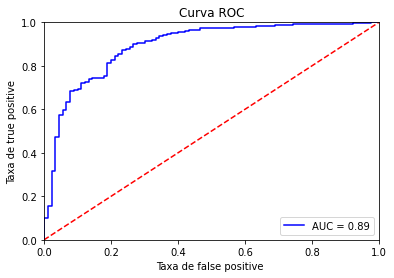

In [21]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):

    model.eval()

    all_logits = []


    for batch in test_dataloader:
        
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
   
    all_logits = torch.cat(all_logits, dim=0)

   
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

#EVALUATION================================

probs = bert_predict(bert_classifier, val_dataloader)
evaluate_roc(probs, y_val)